In [1]:
from Bayesian_NN import sample_posterior_predictive, construct_nn, construct_minibatch_nn
from data_info import MAPPINGS, CONTINUOUS, CATEGORICAL

import arviz as az
import matplotlib.pyplot as plt
import pytensor
from imblearn.under_sampling import RandomUnderSampler 
import numpy as np
import pandas as pd
import pymc as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score

floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
data = pd.read_csv('Flood Data.csv')
data.rename(columns={'SOIL TYPE': 'LITHOLOGY'}, inplace=True)
data = data.loc[:,'HAZARD 1 IN 1000':]
Y = data['HAZARD 1 IN 1000']
X = data.iloc[:,1:]

X = X.astype(floatX)
Y = Y.astype(floatX)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

print("\nNaN's per Feature:")
print(X.isna().sum()) # NaN counts
print(X.shape)

print("\nPre-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split

nan_rows = X.isna().any(axis=1).sum()
print(f"\nRows to remove: {nan_rows} of {len(X)} ({(nan_rows/len(X) * 100).round(2)}%)")
X = X.dropna()
Y = Y.loc[X.index]

print("\nPost-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split



NaN's per Feature:
ELEVATION             797
SLOPE                 998
LANDUSE               866
IMPERVIOUSNESS        678
LITHOLOGY             748
SUBSTRATE             748
NDVI                  905
DISTANCE TO RIVER    1012
BUILDING TYPE         793
DISTANCE TO ROAD     1012
dtype: int64
(67330, 10)

Pre-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.34
1.0     3.06
2.0     1.87
3.0     1.53
4.0     0.19
Name: proportion, dtype: float64

Rows to remove: 1802 of 67330 (2.68%)

Post-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.25
1.0     3.12
2.0     1.90
3.0     1.55
4.0     0.18
Name: proportion, dtype: float64


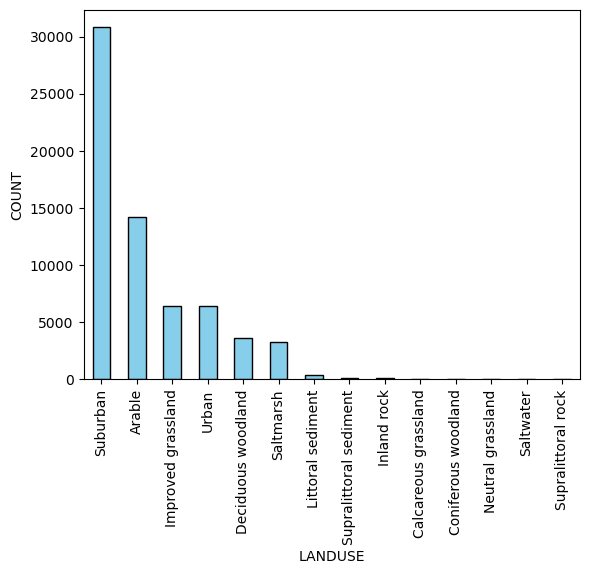

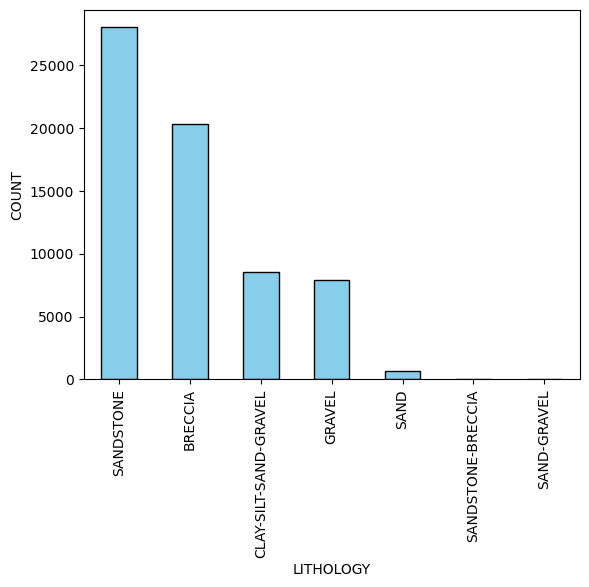

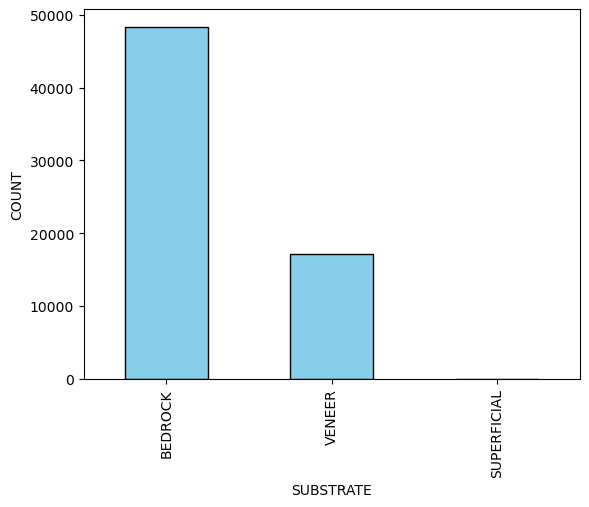

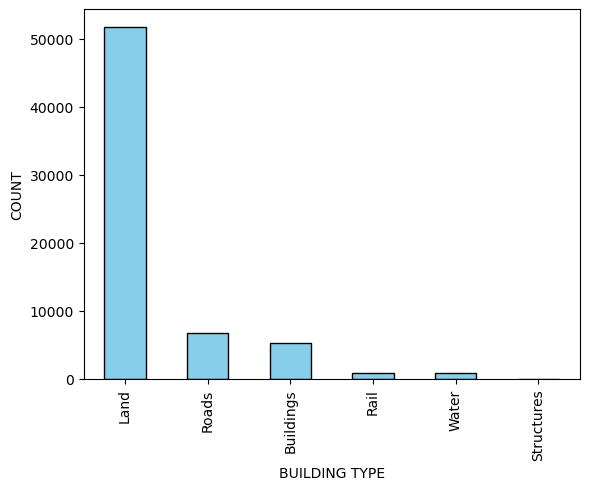

In [3]:
for i in range(len(CATEGORICAL)):
    val_count = X[CATEGORICAL[i]].value_counts(sort=True)
    val_count.index = val_count.index.map(MAPPINGS[i])
    val_count.plot(kind='bar', color="skyblue", edgecolor="black")
    plt.ylabel("COUNT")
    plt.show()

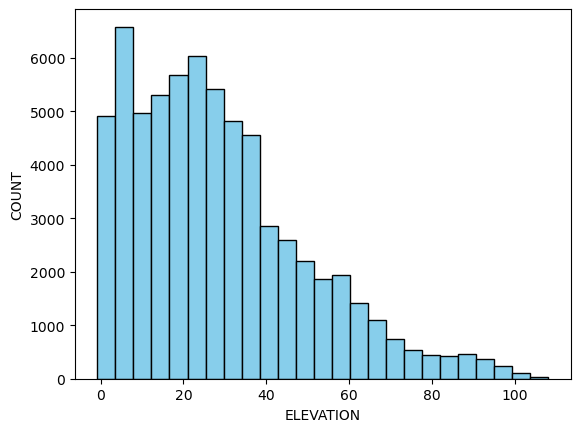

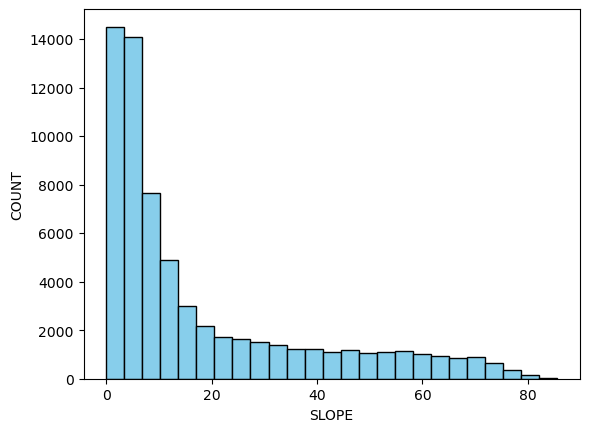

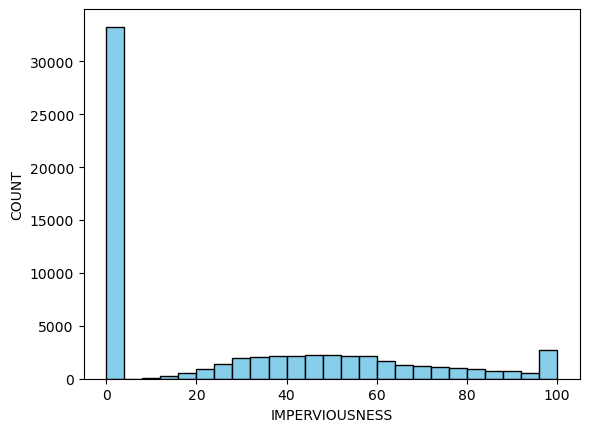

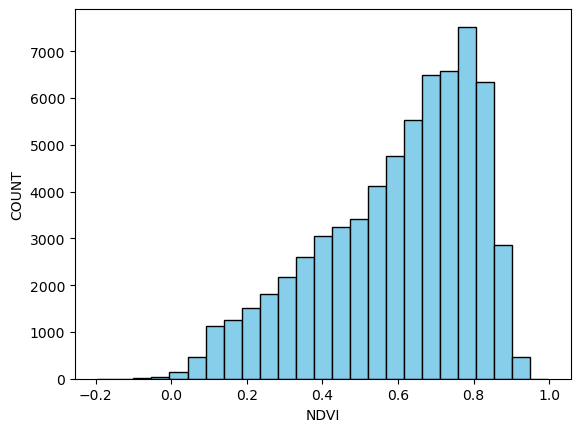

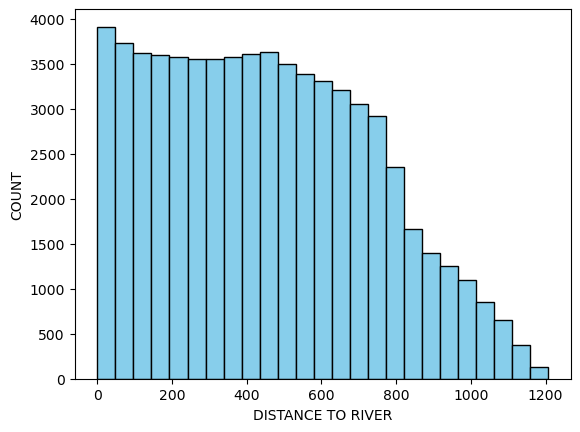

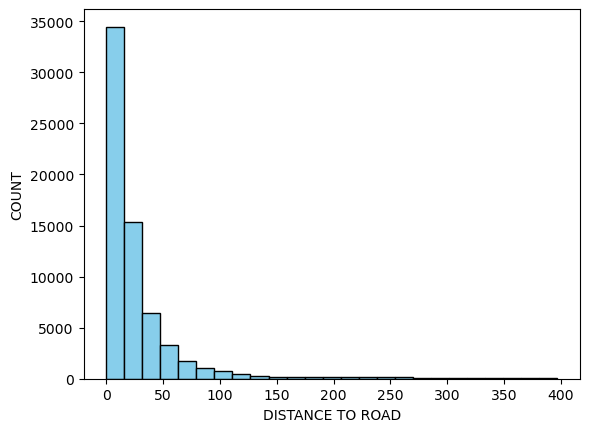

In [4]:
for col in CONTINUOUS:
    plt.hist(X[col], bins = 25, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

### Interpreting the Categorical Data
- SUBSTRATE is an ordinal category; 1 = Bedrock, 2 = Superficial deposit with thin layer, 3 = Superficial deposit - order matters/ bedrock < superficial
- All others are not ordinal so must be OHE
### Interpreting the Continuous Data
- Elevation, slope, and distance to road are logorithmic
- Imperviousness has high number of 0s - more information needed to decide if this should be split into a categorical and continuous feature (i.e. if 0 means something) so will keep as is
- Normalise NDVI
- Standardise all

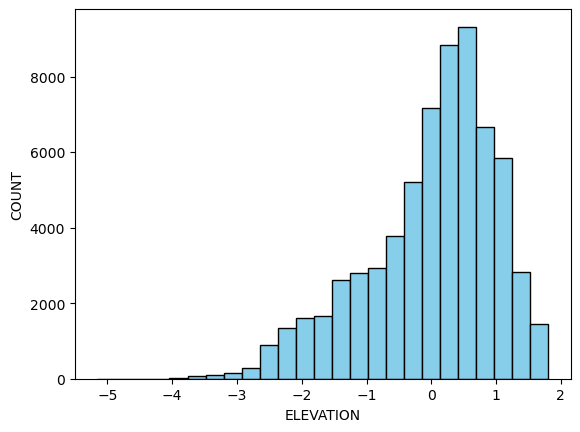

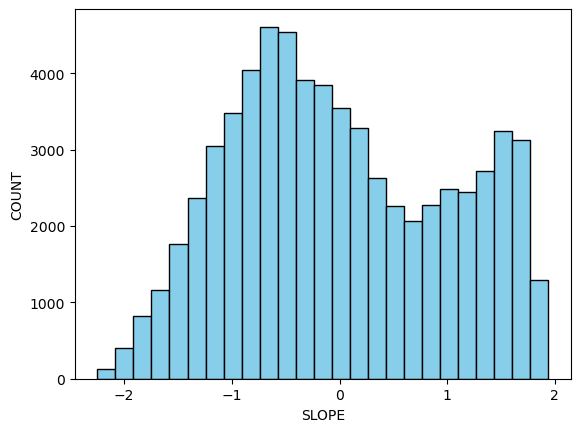

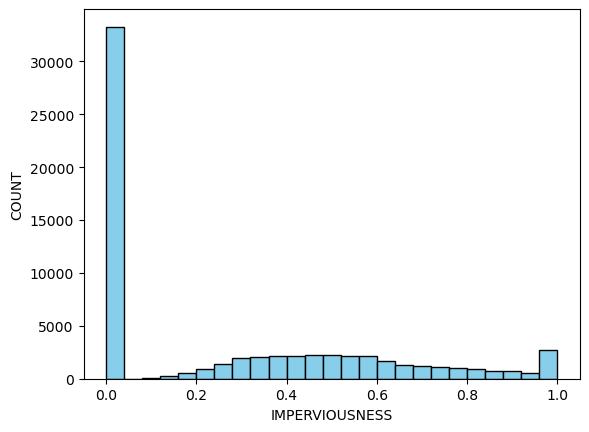

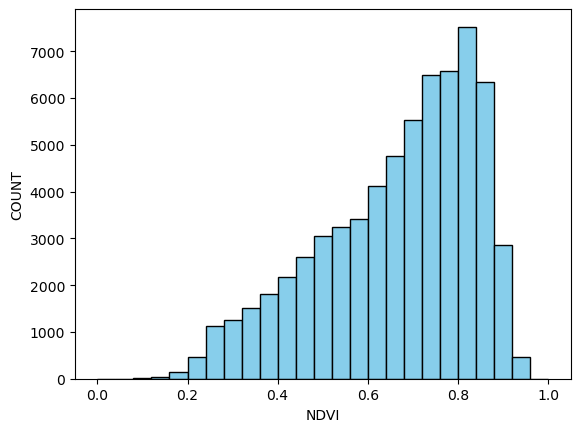

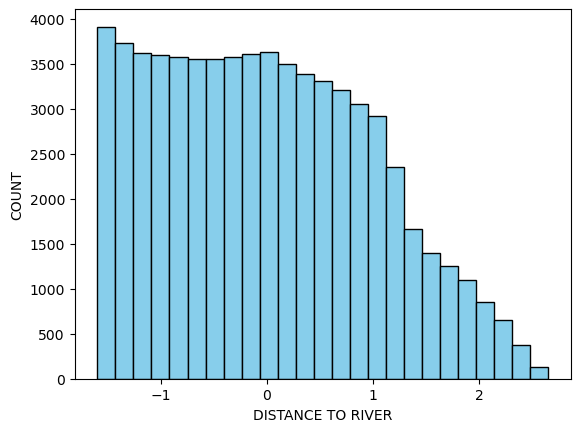

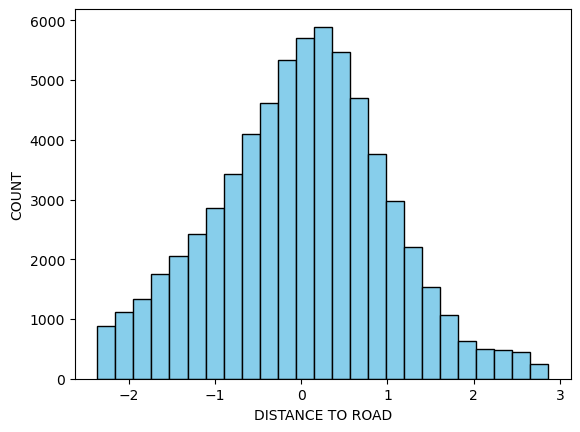

In [5]:
# PREPARE DATA 
LOGORITHMIC = ['ELEVATION','SLOPE', 'DISTANCE TO ROAD']
MIN_MAX = ['IMPERVIOUSNESS', 'NDVI']
STANDARDIZE = list(set(CONTINUOUS) - set(MIN_MAX))
OHE = ["LITHOLOGY", "LANDUSE", "BUILDING TYPE"]

X["NDVI"] = (X["NDVI"] + 1) / 2 # Scales values from [-1,1] to [0,1]

for col in LOGORITHMIC:
    X[col] = np.log1p(X[col])

scalar = MinMaxScaler()
X[MIN_MAX] = scalar.fit_transform(X[MIN_MAX])

scalar = StandardScaler()
X[STANDARDIZE] = scalar.fit_transform(X[STANDARDIZE])

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first")
encoded_data = encoder.fit_transform(X[OHE])
# Convert to DataFrame and ensure index matches X
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(OHE), index=X.index)  # ✅ Fix index
X = pd.concat([X.drop(columns=OHE), encoded_data], axis=1)

for col in CONTINUOUS:
    plt.hist(X[col], bins = 25, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

(6142, 31)
(19659, 31)


Output()

Finished [100%]: Average Loss = 27.69


Text(0.5, 0, 'Iteration')

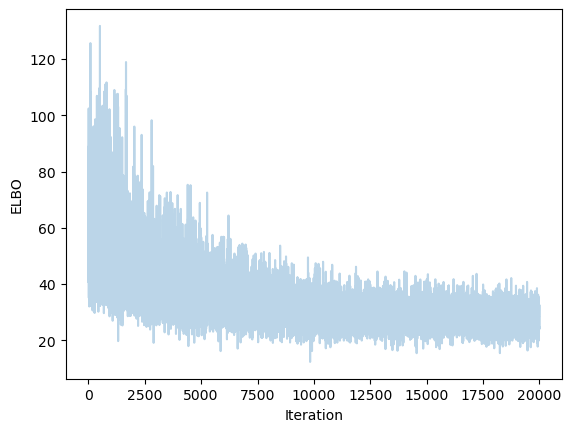

In [6]:
HIDDEN = [5,5]

Y = Y.clip(0,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

rus = RandomUnderSampler()
X_train, Y_train = rus.fit_resample(X_train, Y_train)

print(X_train.shape)
print(X_test.shape)

neural_network = construct_minibatch_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50)

with neural_network:
    approx = pm.fit(n=20000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

Sampling: [out]


Output()

Test Accuracy: 0.7552


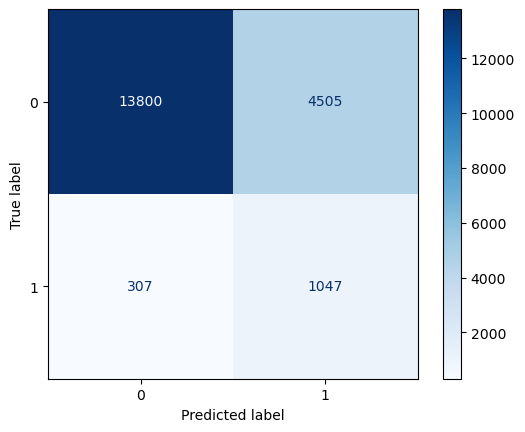

In [7]:
trace_vi = approx.sample(draws=4000, return_inferencedata=True)

ppc = sample_posterior_predictive(X_test, Y_test, trace_vi, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()


## MCMC

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 7 seconds.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 217 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 344 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 1_500 tune and 500 draw iterations (6_000 + 2_000 draws total) took 425 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 446 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 670 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 3_000 tune and 500 draw iterations (12_000 + 2_000 draws total) took 710 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


IndexError: index 6 is out of bounds for axis 0 with size 6

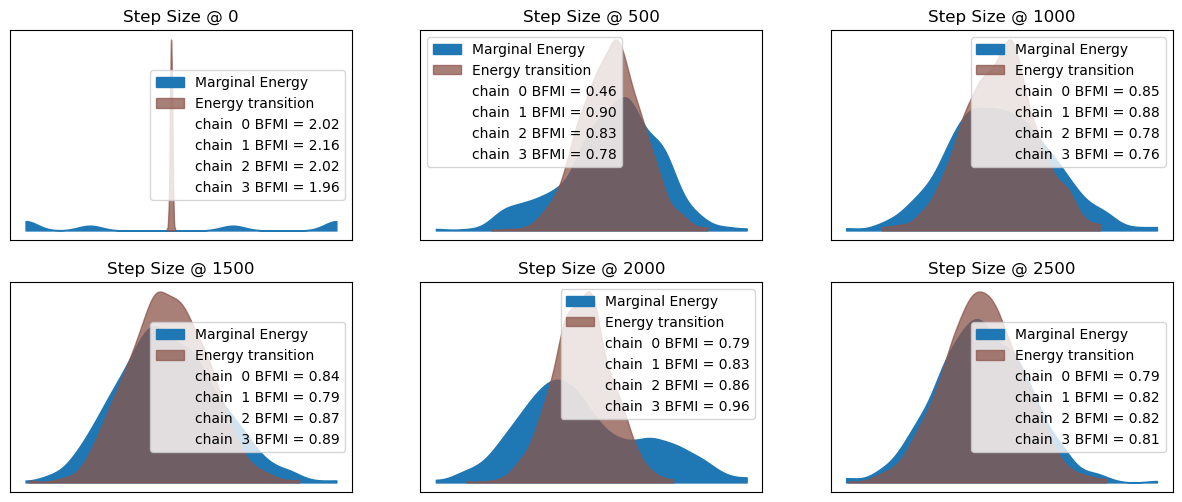

In [79]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

tuning_steps = np.arange(0, 3500, 500)

# Step 3: Run new MCMC chains using different step sizes
traces = []
for tuning_step in tuning_steps:
    with neural_network:
        trace = pm.sample(500, tune=tuning_step, return_inferencedata=True, chains = 4, cores = 4, mp_ctx='spawn')
        traces.append(trace)

# Plot energy distributions to compare efficiency
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # Grid of plots
axes = axes.flatten()

for i, trace in enumerate(traces):
    pm.plot_energy(trace, ax=axes[i])
    axes[i].set_title(f"Step Size @ {tuning_steps[i]}")

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 4 chains for 100 tune and 500 draw iterations (400 + 2_000 draws total) took 451 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

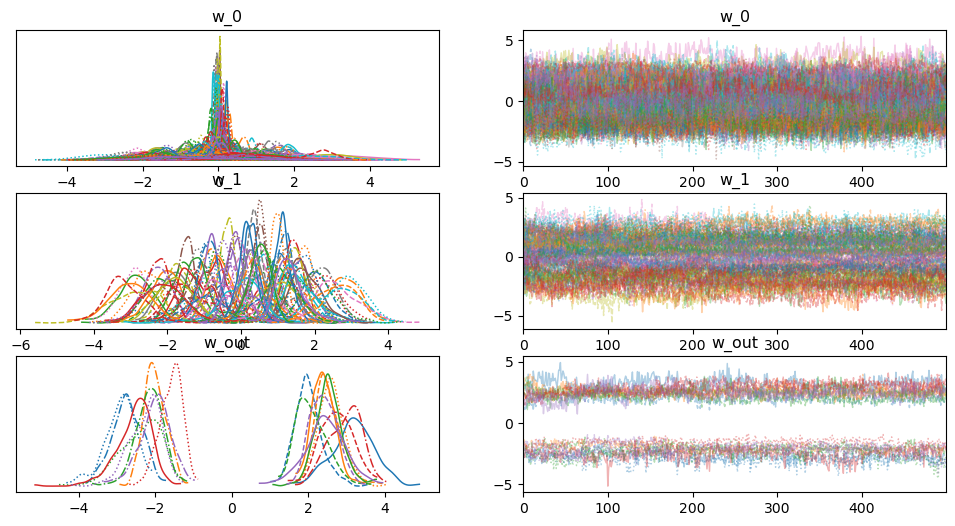

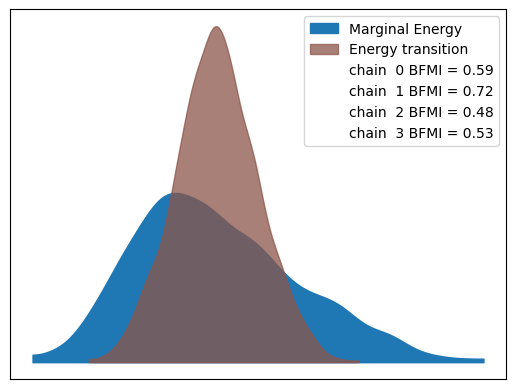

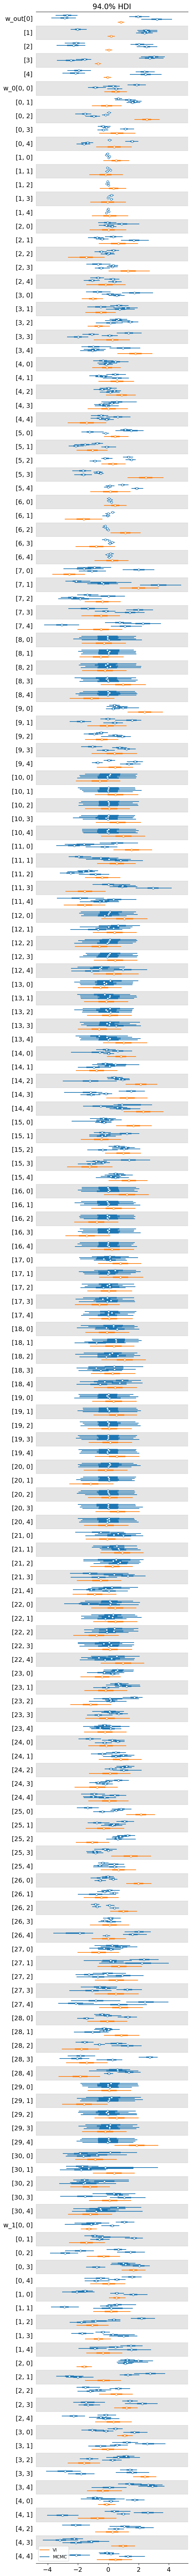

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace_mcmc = pm.sample(100, tune=100, target_accept=0.9, chains = 2,cores = 4, mp_ctx='spawn', discard_tuned_samples=False)

# Plot the trace (posterior samples of weights)
az.plot_trace(trace_mcmc)
pm.plot_energy(trace_mcmc)
az.plot_forest([trace_mcmc, trace_vi], model_names=["MCMC", "VI"])

Burn-in samples: 100
Post-Burn-in samples: 0


IndexError: index 0 is out of bounds for axis 0 with size 0

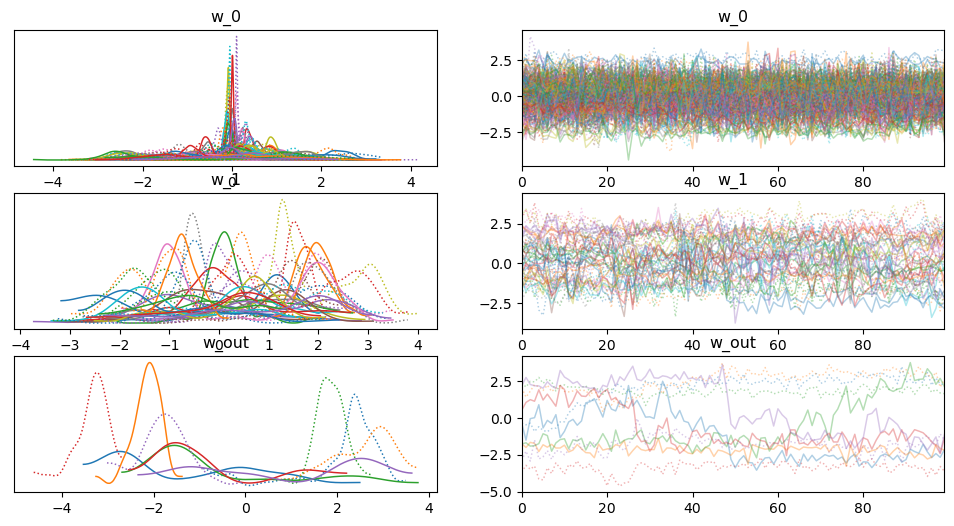

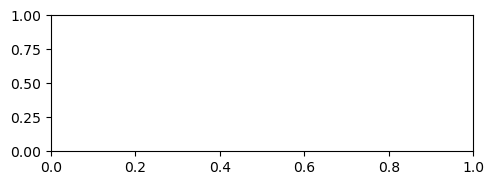

In [60]:

# Define burn-in length (from `tune=100`)
burnin = 100  


# Select burn-in and post-burn-in samples from posterior
burnin_trace = trace_mcmc.posterior.sel(draw=slice(0, burnin))  # First 100 samples
post_burnin_trace = trace_mcmc.posterior.sel(draw=slice(burnin, None))  # Remaining samples

# Check the number of draws in each trace
print(f"Burn-in samples: {burnin_trace.sizes['draw']}")
print(f"Post-Burn-in samples: {post_burnin_trace.sizes['draw']}")

az.plot_trace(burnin_trace)
az.plot_trace(post_burnin_trace)
plt.suptitle("Burn-in (Tuning) Samples")
plt.show()


Sampling: [out]


Output()

KL Divergence (VI vs MCMC): inf
{'w_0': 1.36, 'w_1': 1.66, 'w_out': 1.96}


Test Accuracy: 0.8060
[[14700  3605]
 [  209  1145]]


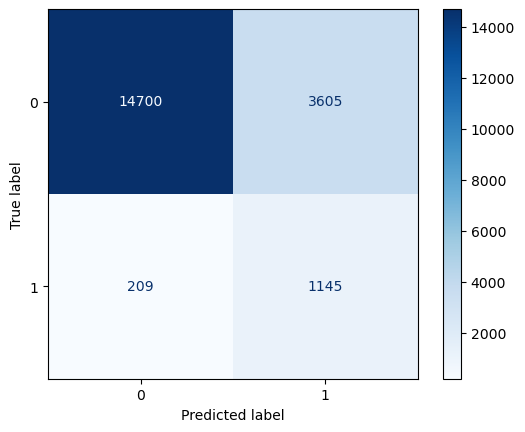

In [55]:
from scipy.stats import entropy
mcmc_samples = trace_mcmc.posterior["w_0"].values.flatten()
vi_samples = trace_vi.posterior["w_0"].values.flatten()
kl_div = entropy(np.histogram(vi_samples, bins=50, density=True)[0], 
                 np.histogram(mcmc_samples, bins=50, density=True)[0])

print("KL Divergence (VI vs MCMC):", kl_div)

rhat = az.rhat(trace_mcmc)
mean_rhat_per_param = {
    param: float(np.mean(rhat[param].values).round(2)) for param in rhat.data_vars
}

print(mean_rhat_per_param)

ppc = sample_posterior_predictive(X_test, Y_test, trace_mcmc, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

{'w_0': [1.346816714313352, 1.3601593202646636, 1.381269002384174, 1.3961778685508979, 1.3965289163719805, 1.4031079310229033, 1.3882355139965872, 1.3651615381453162, 1.3650589812650047, 1.3939377672069186, 1.5180160821168045, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'w_1': [1.5361076715332456, 1.6117288141951662, 1.7171878278338328, 1.7033555452460203, 1.6933627501407071, 1.7215736803912731, 1.6895728534484542, 1.6157858535771428, 1.668080324105562, 1.7449990636881043, 1.7861471066663632, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'w_out': [1.801014907772764, 1.8538431374049975, 1.9092809450200214, 1.9678436481687136, 1.8232209092693534, 1.8420040184861617, 1.9701815398078217, 1.854684377559758, 1.8389230690312282, 1.875579836472274, 1.7728144103158514, nan, nan, nan, nan, nan, nan, nan, nan, nan]}


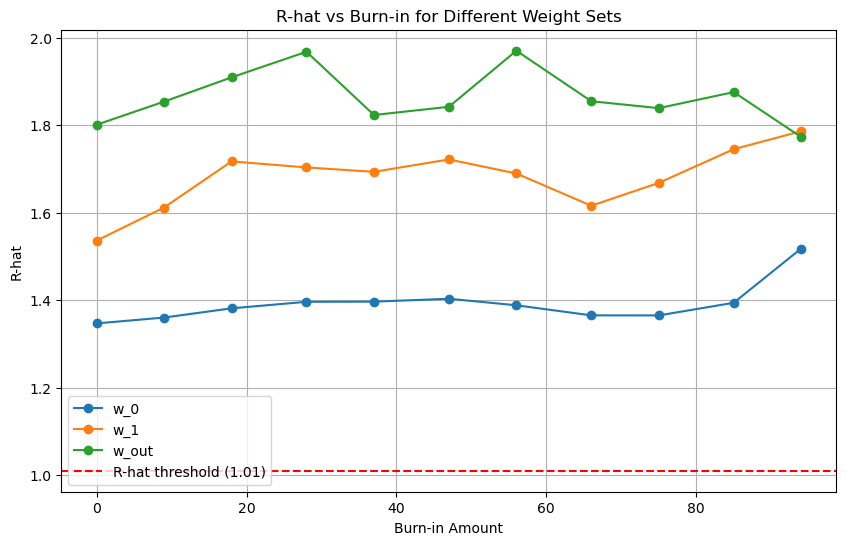

In [53]:
# Define burn-in values to test
burnin_values = np.linspace(0, 180, num=20, dtype=int)  # 10 burn-in values from 0 to 2000

# Store R-hat values per burn-in per parameter
rhat_results = {param: [] for param in trace_mcmc.posterior.data_vars} 

for burnin in burnin_values:
    # Slice the trace to exclude the first `burnin` samples
    trimmed_trace = trace_mcmc.sel(draw=slice(burnin, burnin+20))
    
    # Compute R-hat for the trimmed trace
    rhat_values = az.rhat(trimmed_trace)

    # Store mean R-hat for each parameter
    for param in rhat_results.keys():
        rhat_results[param].append(float(np.mean(rhat_values[param].values)))

# Plot results
plt.figure(figsize=(10, 6))
print(rhat_results)
for param, rhat_values in rhat_results.items():
    plt.plot(burnin_values, rhat_values, marker='o', linestyle='-', label=param)

plt.axhline(y=1.01, color="r", linestyle="--", label="R-hat threshold (1.01)")
plt.xlabel("Burn-in Amount")
plt.ylabel("R-hat")
plt.title("R-hat vs Burn-in for Different Weight Sets")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(2000, tune=2000, discard_tuned_samples=False, target_accept=0.9, return_inferencedata=True, chains=2, cores = 2, mp_ctx='spawn')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1105 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<xarray.DataArray 'energy' (chain: 2, draw: 2000)> Size: 32kB
array([[2616.27724788, 2631.21535985, 2626.97069273, ..., 2615.5775612 ,
        2595.98521109, 2606.57098961],
       [2705.14963933, 2712.24159411, 2713.94734862, ..., 2671.09772431,
        2677.48902729, 2660.99955979]], shape=(2, 2000))
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999


/opt/miniconda3/envs/AI_Coursework/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


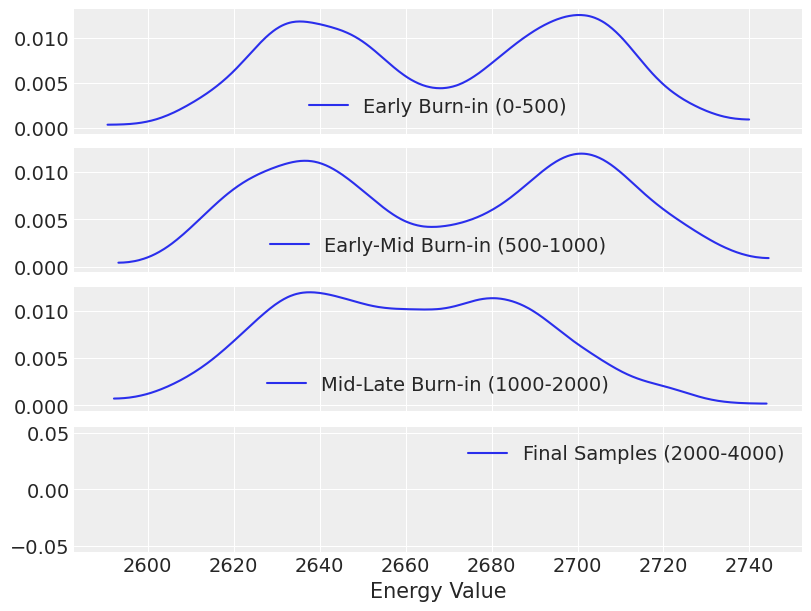

In [ ]:
# Extract energy values (log joint probability)
energy_all = trace.sample_stats["energy"]

# Define different burn-in slices
early_energy = energy_all.isel(draw=slice(0, 500))     # First 500 samples (early burn-in)
mid1_energy = energy_all.isel(draw=slice(500, 1000))   # Middle 500 samples
mid2_energy = energy_all.isel(draw=slice(1000, 2000))  # Post-burn-in (converged samples)
final_energy = energy_all.isel(draw=slice(2000, 4000)) # Post-burn-in (converged samples)
print(energy_all)

# Plot energy distributions for different burn-in stages
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

az.plot_dist(early_energy.values.flatten(), ax=axes[0], label="Early Burn-in (0-500)")
az.plot_dist(mid1_energy.values.flatten(), ax=axes[1], label="Early-Mid Burn-in (500-1000)")
az.plot_dist(mid2_energy.values.flatten(), ax=axes[2], label="Mid-Late Burn-in (1000-2000)")
az.plot_dist(final_energy.values.flatten(), ax=axes[3], label="Final Samples (2000-4000)")
    
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.xlabel("Energy Value")
plt.show()

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [w_0]
>Metropolis: [w_1]
>Metropolis: [w_out]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3867 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'w_0'}>, <Axes: title={'center': 'w_0'}>],
       [<Axes: title={'center': 'w_1'}>, <Axes: title={'center': 'w_1'}>],
       [<Axes: title={'center': 'w_out'}>,
        <Axes: title={'center': 'w_out'}>]], dtype=object)

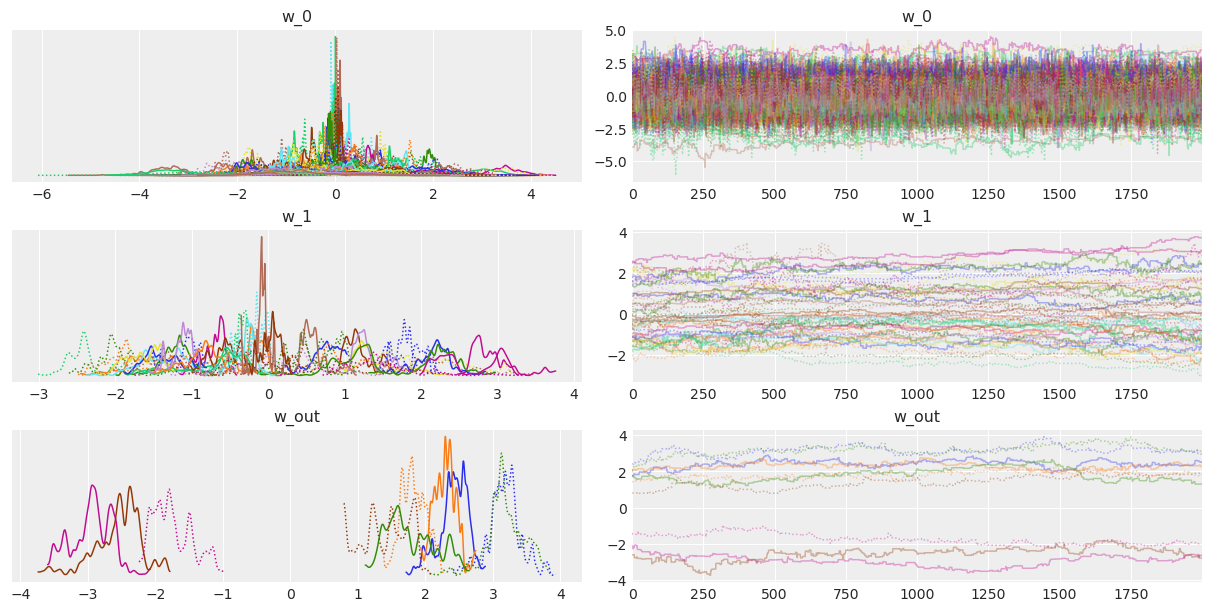

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (Metropolis)
with neural_network:
    step = pm.Metropolis()  # Explicitly choose the Metropolis sampler
    trace = pm.sample(2000, tune=1000, step=step, chains=2, cores = 4, mp_ctx='spawn')  # Use Metropolis

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)

Sampling: [out]


Output()

Test Accuracy: 0.8011
[[14573  3732]
 [  178  1176]]


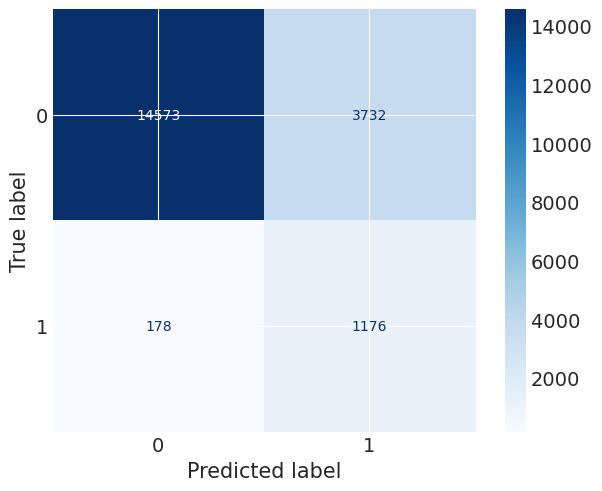

In [ ]:
ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [w_0, w_out]


Output()

/opt/miniconda3/envs/AI_Coursework/lib/python3.13/site-packages/pymc/step_methods/hmc/hmc.py:168: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 113 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'w_0'}>, <Axes: title={'center': 'w_0'}>],
       [<Axes: title={'center': 'w_out'}>,
        <Axes: title={'center': 'w_out'}>]], dtype=object)

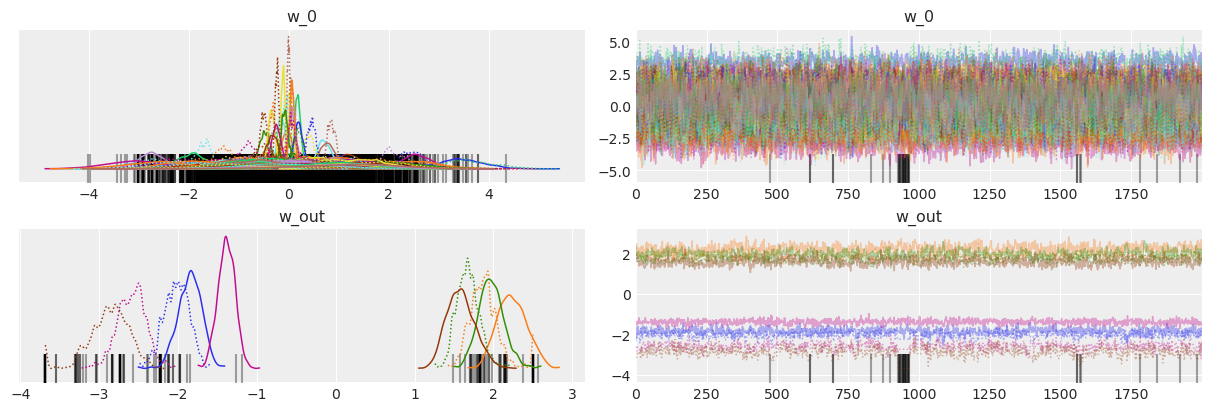

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    step = pm.HamiltonianMC()  # Set an appropriate step size
    trace = pm.sample(2000, tune=1000, step=step, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)

Sampling: [out]


Output()

Test Accuracy: 0.8062
[[14707  3598]
 [  212  1142]]


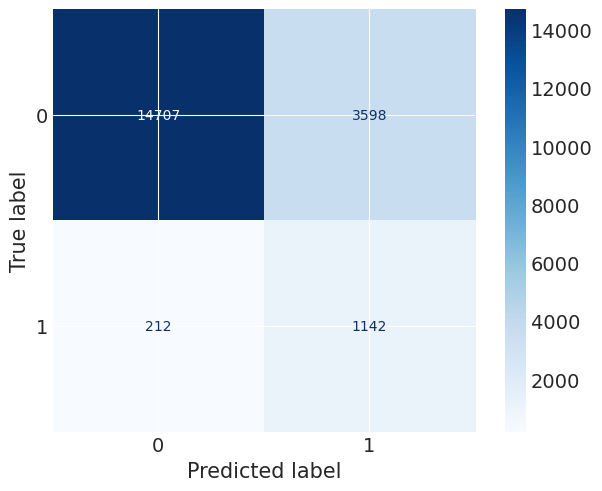

In [ ]:
ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 26.692
Sampling: [out]


Output()

Test Accuracy: 0.7460


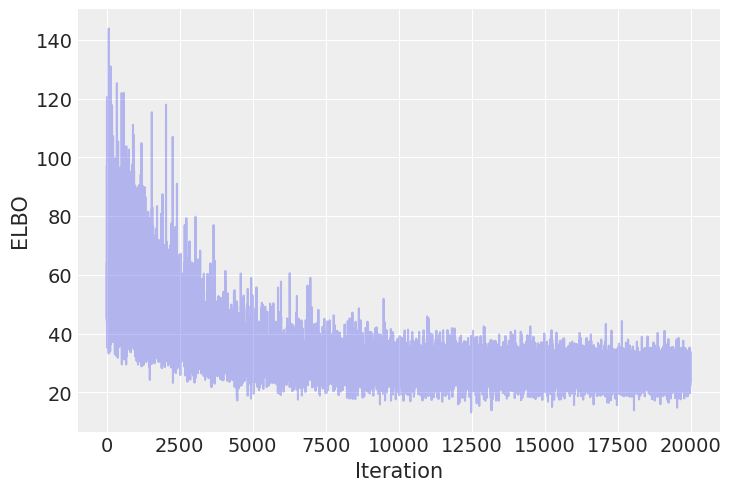

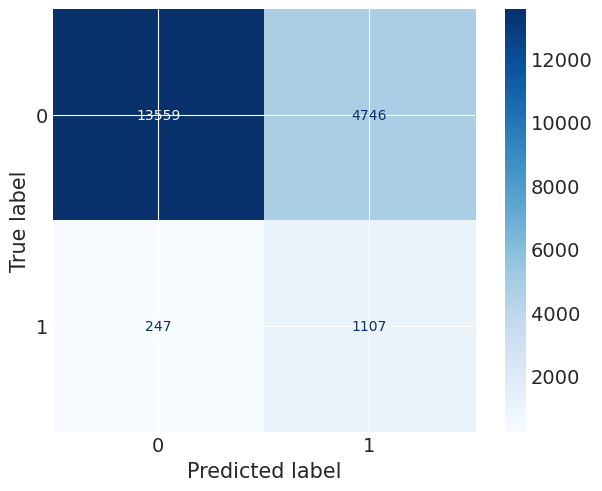

In [ ]:
HIDDEN = [5]

neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50, sigma=0.5, mu = 0)

with neural_network:
    approx = pm.fit(n=20000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

trace = approx.sample(draws=4000)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_out]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 144 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [out]


Output()

Test Accuracy: 0.7728
[[14100  4205]
 [  262  1092]]


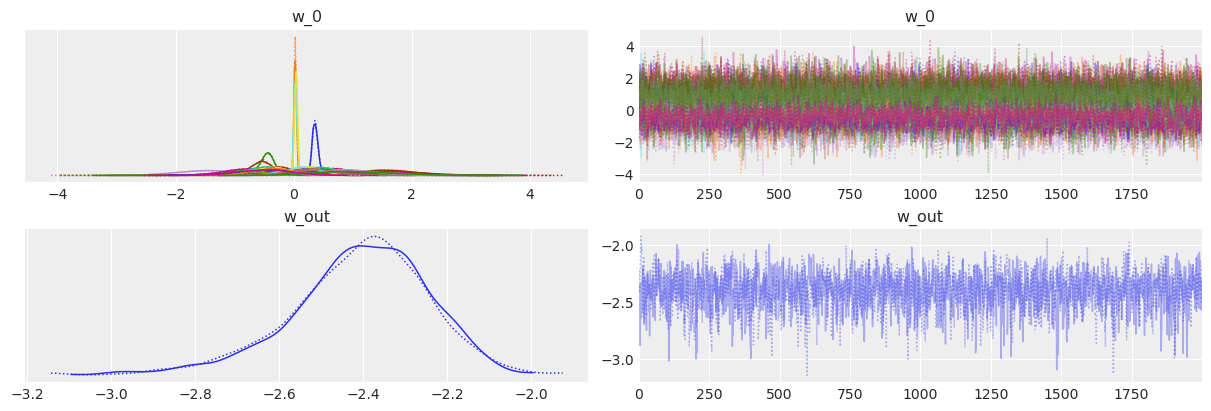

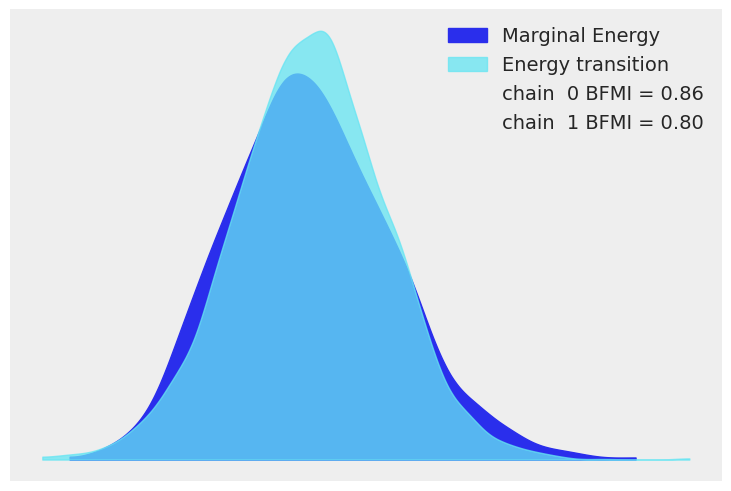

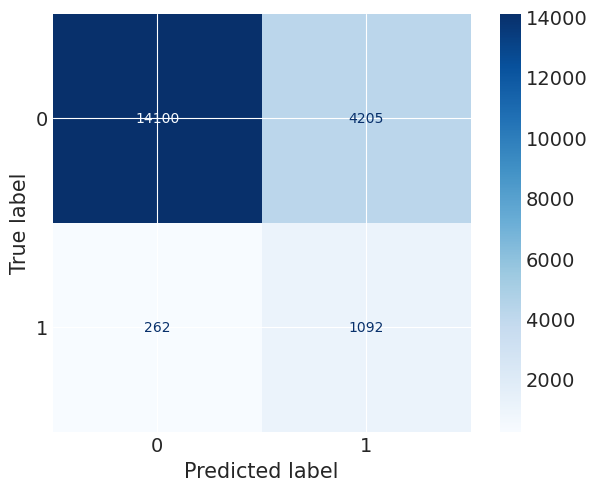

In [ ]:
HIDDEN = [1]
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(2000, tune=1000, target_accept=0.9, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)
pm.plot_energy(trace)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 895 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [out]


Output()

Test Accuracy: 0.8081
[[14701  3604]
 [  169  1185]]


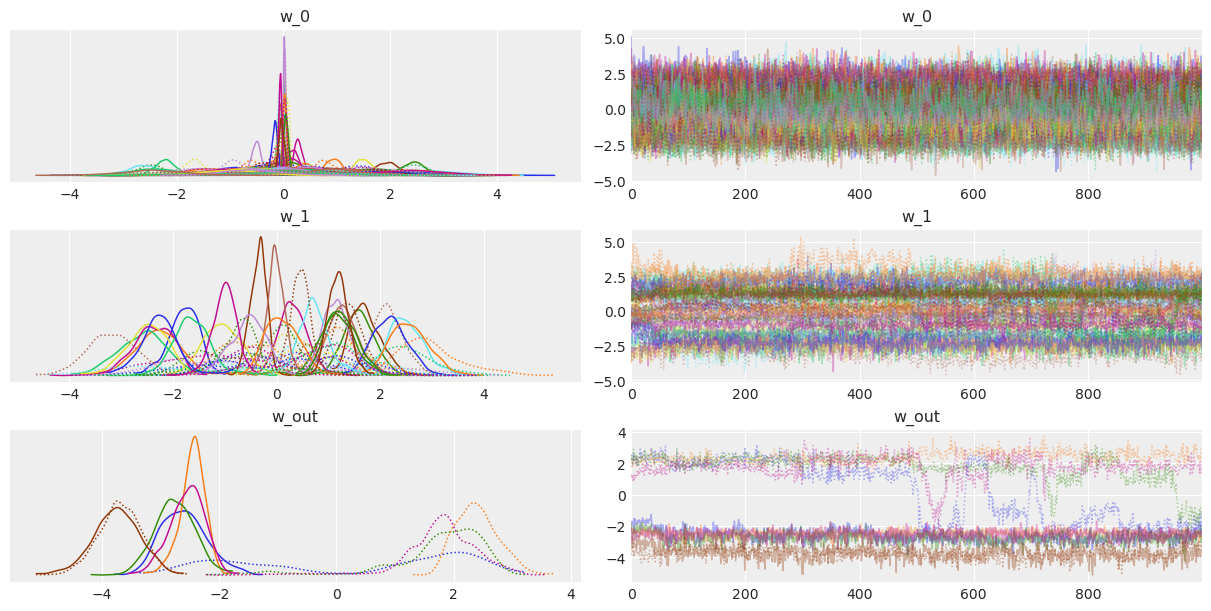

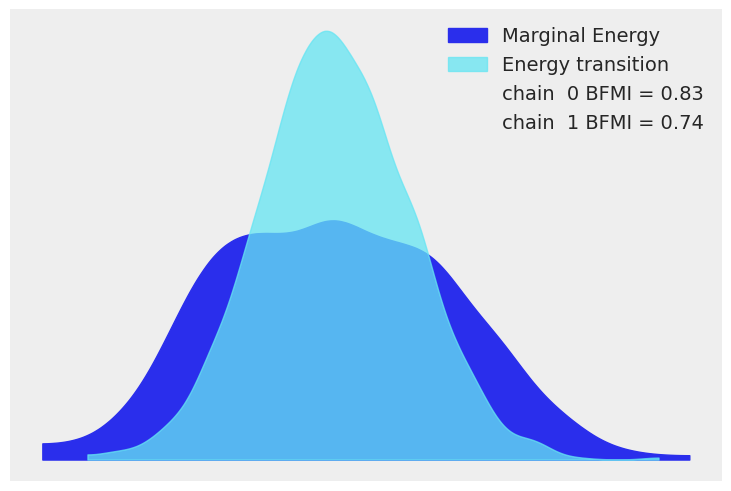

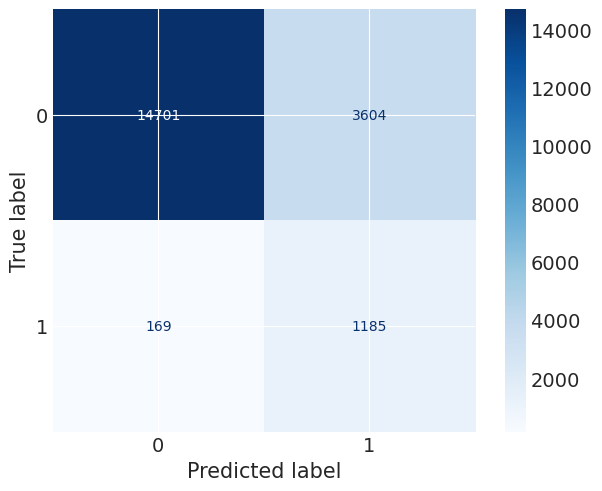

In [ ]:
HIDDEN = [5,5]
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(1000, tune=100, target_accept=0.9, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)
pm.plot_energy(trace)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 3,304.7
Sampling: [out]


Output()

Test Accuracy: 0.7823


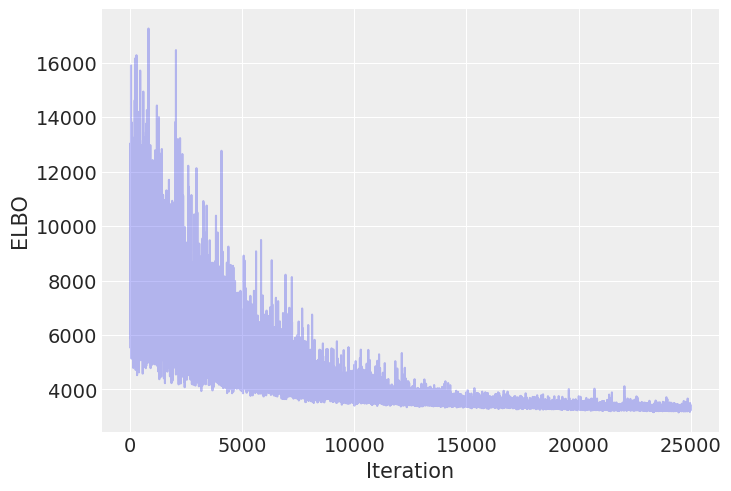

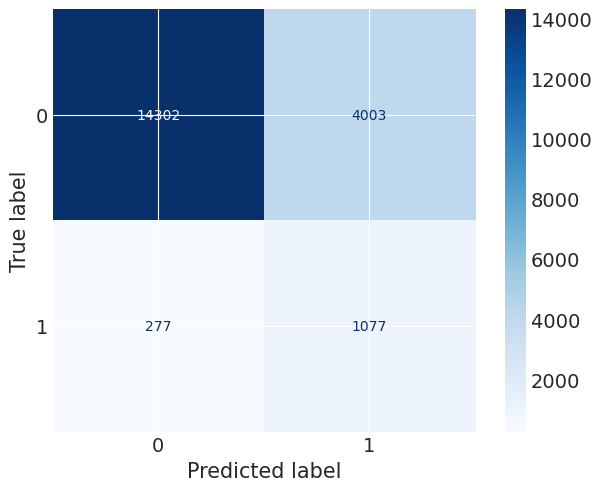

ValueError: Can not extract sample_stats from Inference data with groups:
	> posterior
	> observed_data
	> constant_data! See /opt/miniconda3/envs/AI_Coursework/lib/python3.13/site-packages/arviz/data/converters.py for other conversion utilities.

In [ ]:
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

trace = approx.sample(draws=4000)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()
az.plot_energy(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 95 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [out]


Output()

Test Accuracy: 0.8027
[[14608  3697]
 [  181  1173]]


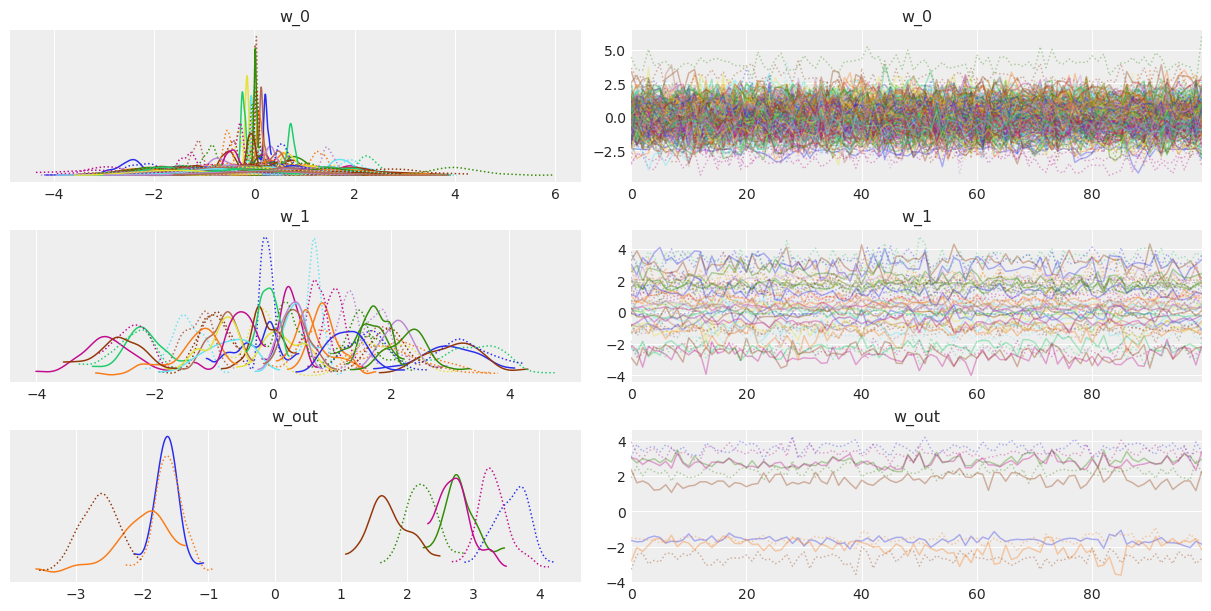

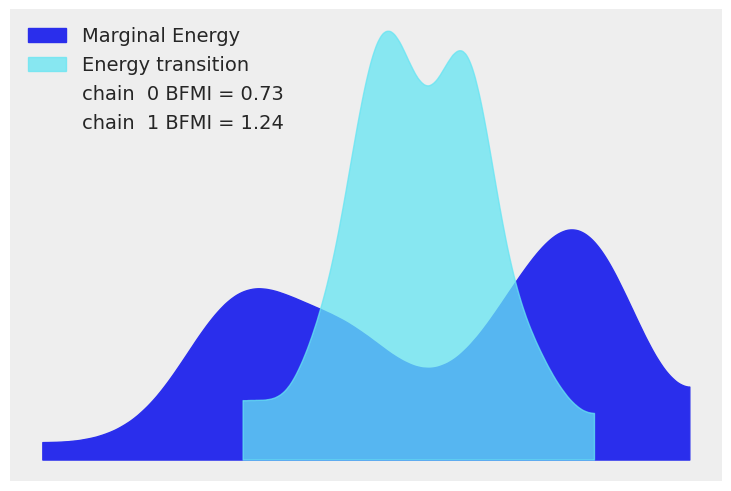

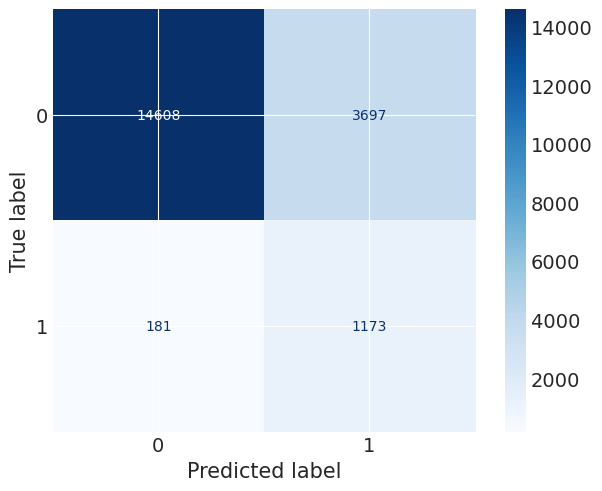

In [ ]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(100, tune=100, target_accept=0.9, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)
pm.plot_energy(trace)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_2, w_out]


Output()

Sampling 2 chains for 200 tune and 100 draw iterations (400 + 200 draws total) took 220 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [out]


Output()

Test Accuracy: 0.8260
[[15045  3260]
 [  161  1193]]


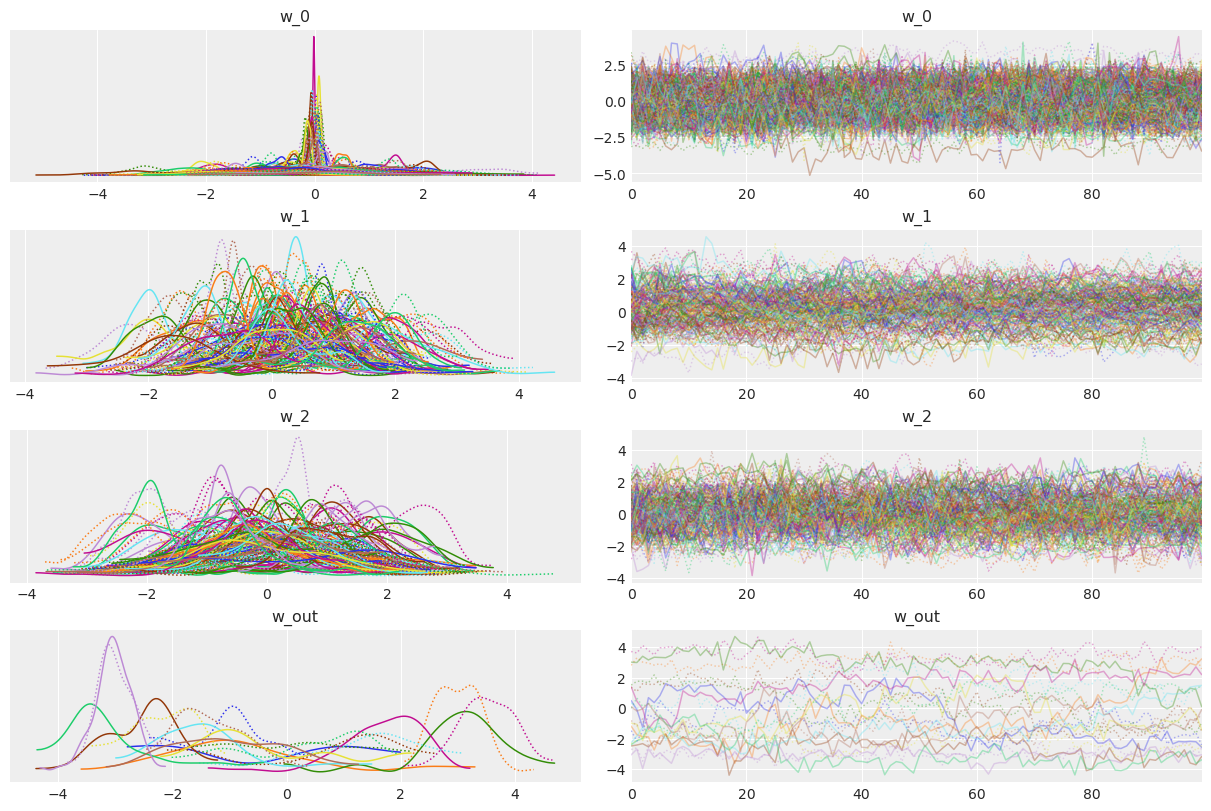

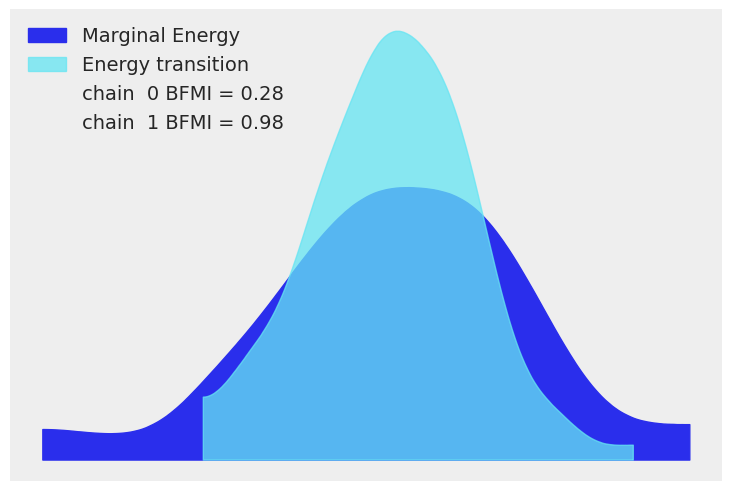

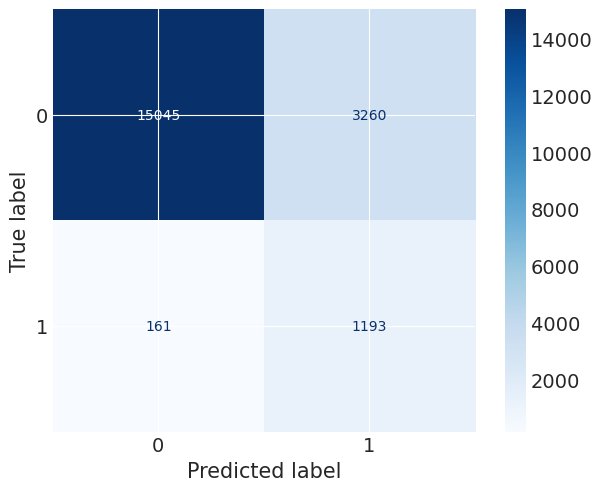

In [ ]:
HIDDEN = [10,10,10]
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(100, tune=200, target_accept=0.9, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)
pm.plot_energy(trace)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Output()

Finished [100%]: Average Loss = 3,353
Sampling: [out]


Output()

Test Accuracy: 0.7799


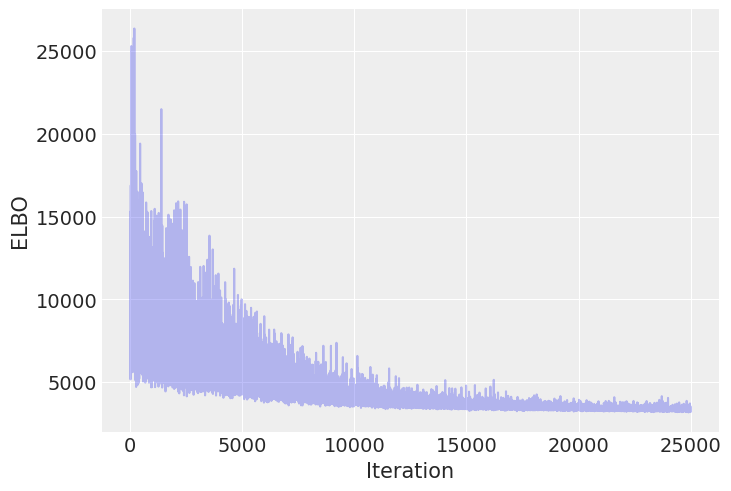

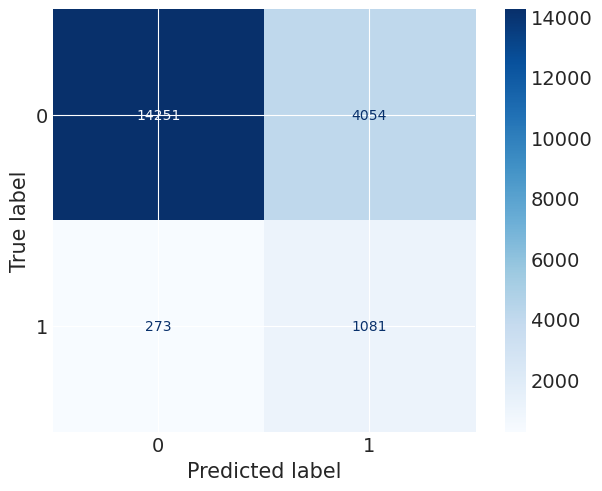

In [ ]:
HIDDEN = [10,10,10]

neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

trace = approx.sample(draws=4000)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 2 chains for 10 tune and 50 draw iterations (20 + 100 draws total) took 26 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [out]


Output()

Test Accuracy: 0.8017
[[14602  3703]
 [  196  1158]]


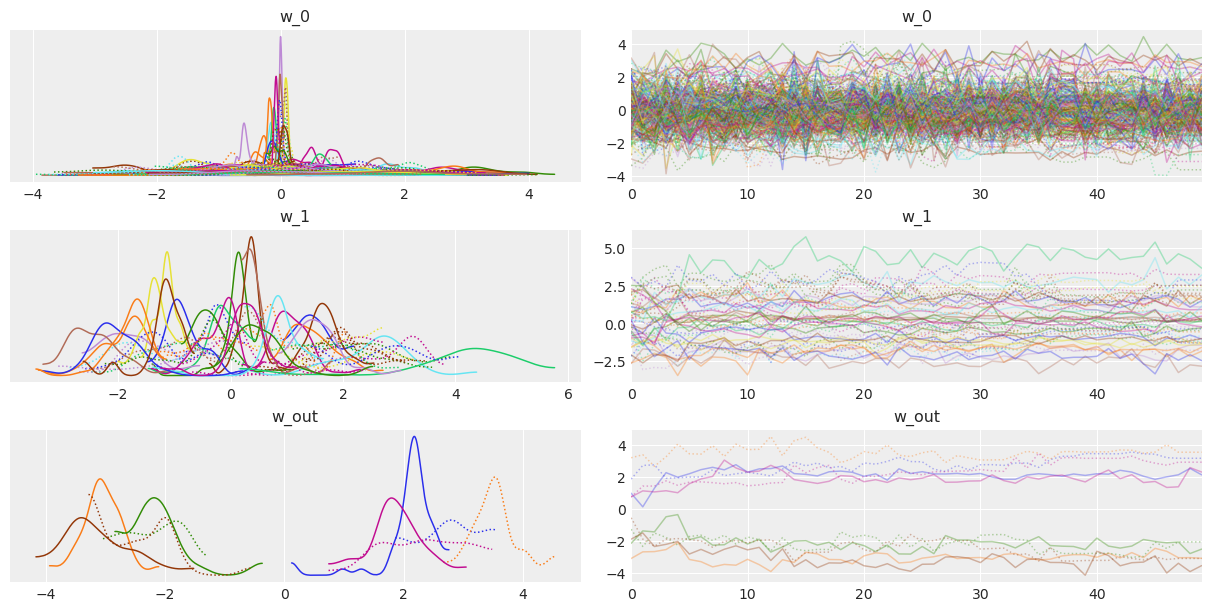

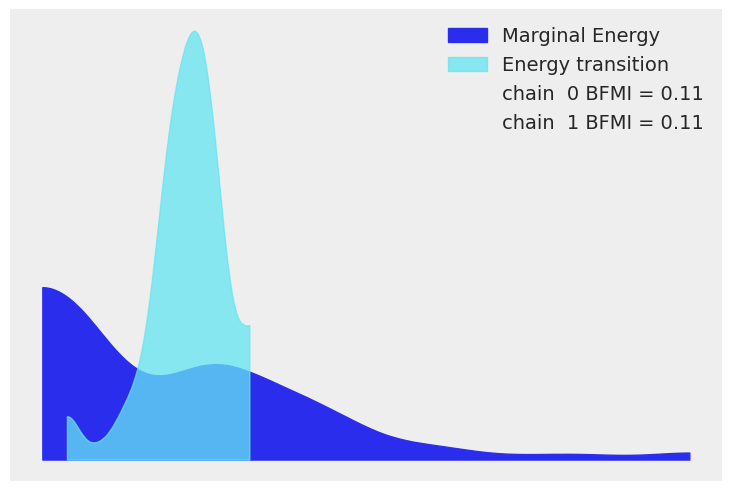

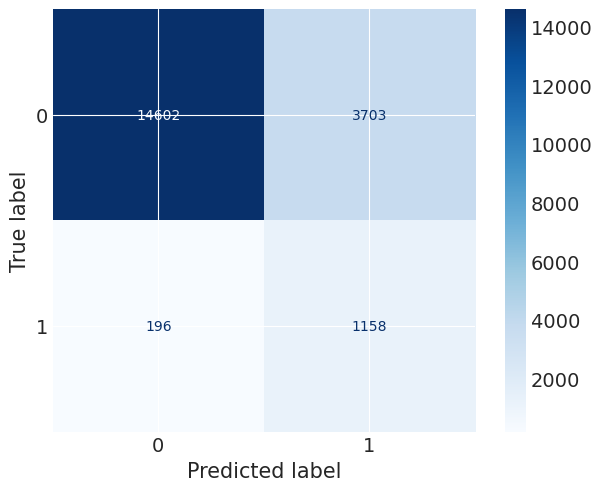

In [ ]:
HIDDEN = [5,5]
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN)

# Use MCMC instead of MCMC (NUTS)
with neural_network:
    trace = pm.sample(50, tune=10, target_accept=0.9, chains=2, cores = 4, mp_ctx='spawn')

# Plot the trace (posterior samples of weights)
az.plot_trace(trace)
pm.plot_energy(trace)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()